# Imports & Data Loading 

In [1]:
#imports 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
import pandas as pd
from PIL import Image
from torch import autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import os
from glob import glob

In [2]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters - Vanilla GAN 
batch_size = 512
epochs = 200
sample_size = 64 
nz = 128 

# Parameters - cGAN 
z_size = 100
img_size = 28 
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]
class_num = 10
learning_rate = 1e-4

In [3]:
# Loading the data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/train-images-idx3-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/train-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../input/data/MNIST/raw



In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# First Model - Vanilla Gan

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
# Define generator and discriminator 
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# Define Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# Define loss function
images = [] 
gan_losses_g = [] 
gan_losses_d = [] 
criterion = nn.BCELoss()

In [ ]:
def noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [ ]:
# Train the discriminator 
def train_disc(optimizer, r_data, f_data):
    size = r_data.size(0)
    r_label =  label_real(size)
    f_label = label_fake(size)
    optimizer.zero_grad()
    r_output = discriminator(r_data)
    r_loss = criterion(r_output, r_label)
    f_output = discriminator(f_data)
    f_loss = criterion(f_output, f_label)
    r_loss.backward()
    f_loss.backward()
    optimizer.step()
    return r_loss + f_loss

# Train the generator 
def train_gen(optimizer, f_data):
    size = f_data.size(0)
    r_label = label_real(size)
    optimizer.zero_grad()
    pred = discriminator(f_data)
    loss = criterion(pred, r_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
noise = noise(sample_size,nz)
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [ ]:
print("\033[1mGenerator architecture is:\n \033[0m ", generator )
print("\033[1mDiscriminator architecture is:\n\033[0m ", discriminator)

Generator architecture is:
   Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator architecture is:
  Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=Tr

In [ ]:
def train_mod(epochs):
  for epoch in range(epochs):
    loss_g, loss_d = 0,0
    for sum, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        for step in range(1):
            f_data = generator(torch.randn(len(image), nz).to(device)).detach()
            r_data = image
            loss_d += train_disc(optimizer_d, r_data, f_data)
        f_data = generator(torch.randn(len(image), nz).to(device))
        loss_g += train_gen(optimizer_g, f_data)
    img = generator(noise).cpu().detach()
    img = make_grid(img)
    save_image(img, f"/content/GAN_outputs/GAN_epoch{epoch+1}.png")
    images.append(img)
    e_loss_g = loss_g /sum
    e_loss_d = loss_d /sum # total discriminator loss for the epoch
    gan_losses_g.append(e_loss_g)
    gan_losses_d.append(e_loss_d)
    
    print("Epoch Number: ",epoch+1)
    print("Generator loss is  ", round(e_loss_g.detach().item(),4))
    print("Discriminator loss is: ", round(e_loss_d.detach().item(),4)) 

In [ ]:
train_mod(epochs)

118it [00:11, 10.68it/s]                         


Epoch Number:  1
Generator loss is   1.2692
Discriminator loss is:  0.919


118it [00:11, 10.71it/s]


Epoch Number:  2
Generator loss is   3.1138
Discriminator loss is:  1.4253


118it [00:10, 10.74it/s]                         


Epoch Number:  3
Generator loss is   4.8863
Discriminator loss is:  0.2183


118it [00:10, 10.89it/s]


Epoch Number:  4
Generator loss is   3.9191
Discriminator loss is:  0.7348


118it [00:10, 10.82it/s]


Epoch Number:  5
Generator loss is   3.9082
Discriminator loss is:  0.5668


118it [00:11, 10.54it/s]                         


Epoch Number:  6
Generator loss is   2.4515
Discriminator loss is:  0.9006


118it [00:11, 10.63it/s]                         


Epoch Number:  7
Generator loss is   2.9123
Discriminator loss is:  0.8719


118it [00:11, 10.66it/s]                         


Epoch Number:  8
Generator loss is   2.3348
Discriminator loss is:  1.0526


118it [00:10, 10.73it/s]                         


Epoch Number:  9
Generator loss is   1.7246
Discriminator loss is:  0.8559


118it [00:11, 10.68it/s]                         


Epoch Number:  10
Generator loss is   2.7072
Discriminator loss is:  1.044


118it [00:10, 10.82it/s]


Epoch Number:  11
Generator loss is   1.6886
Discriminator loss is:  1.246


118it [00:11, 10.66it/s]


Epoch Number:  12
Generator loss is   1.7013
Discriminator loss is:  1.3675


118it [00:11, 10.68it/s]


Epoch Number:  13
Generator loss is   1.4023
Discriminator loss is:  0.9087


118it [00:11, 10.68it/s]


Epoch Number:  14
Generator loss is   0.9787
Discriminator loss is:  1.2099


118it [00:10, 10.83it/s]


Epoch Number:  15
Generator loss is   2.0197
Discriminator loss is:  0.5183


118it [00:11, 10.72it/s]


Epoch Number:  16
Generator loss is   2.8886
Discriminator loss is:  0.3551


118it [00:11, 10.58it/s]


Epoch Number:  17
Generator loss is   3.3088
Discriminator loss is:  0.3139


118it [00:11, 10.67it/s]


Epoch Number:  18
Generator loss is   3.9603
Discriminator loss is:  0.2202


118it [00:10, 11.03it/s]


Epoch Number:  19
Generator loss is   4.6522
Discriminator loss is:  0.1394


118it [00:10, 11.00it/s]


Epoch Number:  20
Generator loss is   4.2614
Discriminator loss is:  0.3486


118it [00:10, 10.76it/s]                         


Epoch Number:  21
Generator loss is   4.3137
Discriminator loss is:  0.2764


118it [00:10, 10.91it/s]


Epoch Number:  22
Generator loss is   3.9586
Discriminator loss is:  0.603


118it [00:10, 10.81it/s]


Epoch Number:  23
Generator loss is   4.3059
Discriminator loss is:  0.5042


118it [00:11, 10.71it/s]


Epoch Number:  24
Generator loss is   3.3587
Discriminator loss is:  0.529


118it [00:10, 10.85it/s]


Epoch Number:  25
Generator loss is   3.0838
Discriminator loss is:  0.4779


118it [00:10, 10.79it/s]                         


Epoch Number:  26
Generator loss is   3.053
Discriminator loss is:  0.5117


118it [00:10, 10.80it/s]


Epoch Number:  27
Generator loss is   2.4123
Discriminator loss is:  0.6256


118it [00:11, 10.60it/s]                         


Epoch Number:  28
Generator loss is   3.0582
Discriminator loss is:  0.4635


118it [00:11, 10.68it/s]


Epoch Number:  29
Generator loss is   2.8697
Discriminator loss is:  0.5768


118it [00:11, 10.63it/s]


Epoch Number:  30
Generator loss is   2.4163
Discriminator loss is:  0.5475


118it [00:10, 10.78it/s]


Epoch Number:  31
Generator loss is   2.9879
Discriminator loss is:  0.4886


118it [00:10, 10.89it/s]


Epoch Number:  32
Generator loss is   2.9589
Discriminator loss is:  0.531


118it [00:10, 11.07it/s]


Epoch Number:  33
Generator loss is   3.0117
Discriminator loss is:  0.5544


118it [00:10, 10.86it/s]                         


Epoch Number:  34
Generator loss is   2.8106
Discriminator loss is:  0.5632


118it [00:10, 10.80it/s]


Epoch Number:  35
Generator loss is   3.0023
Discriminator loss is:  0.4611


118it [00:11, 10.67it/s]


Epoch Number:  36
Generator loss is   2.6668
Discriminator loss is:  0.644


118it [00:10, 10.88it/s]


Epoch Number:  37
Generator loss is   2.3727
Discriminator loss is:  0.6665


118it [00:10, 10.75it/s]


Epoch Number:  38
Generator loss is   2.6173
Discriminator loss is:  0.5432


118it [00:11, 10.68it/s]


Epoch Number:  39
Generator loss is   2.5617
Discriminator loss is:  0.5949


118it [00:11, 10.67it/s]                         


Epoch Number:  40
Generator loss is   2.7805
Discriminator loss is:  0.5288


118it [00:10, 10.81it/s]                         


Epoch Number:  41
Generator loss is   2.7741
Discriminator loss is:  0.5215


118it [00:10, 10.96it/s]


Epoch Number:  42
Generator loss is   2.8114
Discriminator loss is:  0.5576


118it [00:10, 10.84it/s]


Epoch Number:  43
Generator loss is   2.4164
Discriminator loss is:  0.6534


118it [00:10, 10.81it/s]


Epoch Number:  44
Generator loss is   2.3411
Discriminator loss is:  0.6423


118it [00:11, 10.72it/s]


Epoch Number:  45
Generator loss is   2.5163
Discriminator loss is:  0.5794


118it [00:11, 10.63it/s]                         


Epoch Number:  46
Generator loss is   2.3745
Discriminator loss is:  0.6564


118it [00:10, 10.82it/s]


Epoch Number:  47
Generator loss is   2.2711
Discriminator loss is:  0.6796


118it [00:10, 10.97it/s]


Epoch Number:  48
Generator loss is   2.1659
Discriminator loss is:  0.7162


118it [00:10, 10.82it/s]


Epoch Number:  49
Generator loss is   2.1019
Discriminator loss is:  0.7061


118it [00:11, 10.51it/s]                         


Epoch Number:  50
Generator loss is   2.0622
Discriminator loss is:  0.7337


118it [00:10, 10.81it/s]


Epoch Number:  51
Generator loss is   2.0986
Discriminator loss is:  0.7608


118it [00:10, 10.81it/s]


Epoch Number:  52
Generator loss is   2.146
Discriminator loss is:  0.6422


118it [00:10, 10.86it/s]


Epoch Number:  53
Generator loss is   2.4717
Discriminator loss is:  0.6925


118it [00:10, 10.85it/s]                         


Epoch Number:  54
Generator loss is   2.2554
Discriminator loss is:  0.7371


118it [00:10, 10.73it/s]


Epoch Number:  55
Generator loss is   2.2745
Discriminator loss is:  0.6364


118it [00:11, 10.63it/s]


Epoch Number:  56
Generator loss is   2.5612
Discriminator loss is:  0.6227


118it [00:10, 10.80it/s]                         


Epoch Number:  57
Generator loss is   2.5811
Discriminator loss is:  0.6678


118it [00:10, 10.79it/s]


Epoch Number:  58
Generator loss is   2.291
Discriminator loss is:  0.6625


118it [00:11, 10.63it/s]                         


Epoch Number:  59
Generator loss is   2.2902
Discriminator loss is:  0.6684


118it [00:11, 10.58it/s]


Epoch Number:  60
Generator loss is   2.6264
Discriminator loss is:  0.6286


118it [00:11, 10.69it/s]


Epoch Number:  61
Generator loss is   2.0411
Discriminator loss is:  0.7783


118it [00:10, 10.88it/s]


Epoch Number:  62
Generator loss is   2.1394
Discriminator loss is:  0.684


118it [00:10, 10.82it/s]                         


Epoch Number:  63
Generator loss is   2.4488
Discriminator loss is:  0.6156


118it [00:10, 10.96it/s]                         


Epoch Number:  64
Generator loss is   2.2645
Discriminator loss is:  0.6816


118it [00:10, 10.83it/s]


Epoch Number:  65
Generator loss is   2.2969
Discriminator loss is:  0.7023


118it [00:10, 10.77it/s]                         


Epoch Number:  66
Generator loss is   2.2185
Discriminator loss is:  0.7058


118it [00:10, 10.91it/s]


Epoch Number:  67
Generator loss is   2.3512
Discriminator loss is:  0.6748


118it [00:10, 10.73it/s]


Epoch Number:  68
Generator loss is   1.8873
Discriminator loss is:  0.8262


118it [00:11, 10.67it/s]


Epoch Number:  69
Generator loss is   2.098
Discriminator loss is:  0.7394


118it [00:10, 10.75it/s]


Epoch Number:  70
Generator loss is   1.9913
Discriminator loss is:  0.7373


118it [00:11, 10.67it/s]


Epoch Number:  71
Generator loss is   2.1657
Discriminator loss is:  0.709


118it [00:11, 10.69it/s]


Epoch Number:  72
Generator loss is   2.0361
Discriminator loss is:  0.7549


118it [00:11, 10.72it/s]


Epoch Number:  73
Generator loss is   1.9862
Discriminator loss is:  0.7604


118it [00:11, 10.68it/s]


Epoch Number:  74
Generator loss is   2.0481
Discriminator loss is:  0.7376


118it [00:10, 10.81it/s]


Epoch Number:  75
Generator loss is   2.2942
Discriminator loss is:  0.7001


118it [00:10, 10.91it/s]


Epoch Number:  76
Generator loss is   2.1297
Discriminator loss is:  0.7165


118it [00:11, 10.55it/s]


Epoch Number:  77
Generator loss is   2.0806
Discriminator loss is:  0.7344


118it [00:10, 10.85it/s]


Epoch Number:  78
Generator loss is   2.1047
Discriminator loss is:  0.7388


118it [00:10, 10.77it/s]


Epoch Number:  79
Generator loss is   2.1687
Discriminator loss is:  0.7511


118it [00:11, 10.68it/s]


Epoch Number:  80
Generator loss is   1.9263
Discriminator loss is:  0.7907


118it [00:10, 10.80it/s]


Epoch Number:  81
Generator loss is   2.0931
Discriminator loss is:  0.7359


118it [00:11, 10.59it/s]


Epoch Number:  82
Generator loss is   2.0736
Discriminator loss is:  0.7235


118it [00:11, 10.67it/s]


Epoch Number:  83
Generator loss is   2.0416
Discriminator loss is:  0.7469


118it [00:11, 10.69it/s]


Epoch Number:  84
Generator loss is   2.0389
Discriminator loss is:  0.7649


118it [00:10, 10.76it/s]


Epoch Number:  85
Generator loss is   2.1542
Discriminator loss is:  0.7405


118it [00:10, 10.93it/s]


Epoch Number:  86
Generator loss is   1.9288
Discriminator loss is:  0.7889


118it [00:11, 10.66it/s]                         


Epoch Number:  87
Generator loss is   2.0674
Discriminator loss is:  0.749


118it [00:11, 10.70it/s]                         


Epoch Number:  88
Generator loss is   2.0746
Discriminator loss is:  0.7338


118it [00:10, 10.78it/s]                         


Epoch Number:  89
Generator loss is   2.0264
Discriminator loss is:  0.8055


118it [00:10, 10.84it/s]


Epoch Number:  90
Generator loss is   2.0066
Discriminator loss is:  0.789


118it [00:10, 10.81it/s]


Epoch Number:  91
Generator loss is   1.9674
Discriminator loss is:  0.8213


118it [00:10, 11.02it/s]


Epoch Number:  92
Generator loss is   1.9417
Discriminator loss is:  0.7978


118it [00:10, 10.87it/s]


Epoch Number:  93
Generator loss is   1.9791
Discriminator loss is:  0.7869


118it [00:10, 10.82it/s]                         


Epoch Number:  94
Generator loss is   1.9957
Discriminator loss is:  0.8013


118it [00:10, 10.88it/s]


Epoch Number:  95
Generator loss is   2.0884
Discriminator loss is:  0.7714


118it [00:10, 10.86it/s]


Epoch Number:  96
Generator loss is   1.9962
Discriminator loss is:  0.748


118it [00:10, 11.02it/s]                         


Epoch Number:  97
Generator loss is   2.0564
Discriminator loss is:  0.7578


118it [00:10, 11.12it/s]


Epoch Number:  98
Generator loss is   2.0231
Discriminator loss is:  0.7754


118it [00:11, 10.18it/s]


Epoch Number:  99
Generator loss is   1.8239
Discriminator loss is:  0.8427


118it [00:10, 10.95it/s]


Epoch Number:  100
Generator loss is   1.881
Discriminator loss is:  0.7928


118it [00:10, 10.92it/s]


Epoch Number:  101
Generator loss is   2.0277
Discriminator loss is:  0.7567


118it [00:10, 10.94it/s]


Epoch Number:  102
Generator loss is   1.9088
Discriminator loss is:  0.8071


118it [00:11, 10.69it/s]                         


Epoch Number:  103
Generator loss is   1.8309
Discriminator loss is:  0.8165


118it [00:11, 10.71it/s]                         


Epoch Number:  104
Generator loss is   1.8752
Discriminator loss is:  0.8255


118it [00:11, 10.61it/s]


Epoch Number:  105
Generator loss is   1.9348
Discriminator loss is:  0.7943


118it [00:10, 10.76it/s]


Epoch Number:  106
Generator loss is   1.9279
Discriminator loss is:  0.7811


118it [00:10, 10.96it/s]


Epoch Number:  107
Generator loss is   1.8808
Discriminator loss is:  0.8034


118it [00:10, 10.85it/s]


Epoch Number:  108
Generator loss is   1.8598
Discriminator loss is:  0.8246


118it [00:10, 10.73it/s]


Epoch Number:  109
Generator loss is   1.8369
Discriminator loss is:  0.8289


118it [00:11, 10.69it/s]


Epoch Number:  110
Generator loss is   1.8553
Discriminator loss is:  0.8108


118it [00:10, 10.77it/s]


Epoch Number:  111
Generator loss is   1.7881
Discriminator loss is:  0.8649


118it [00:10, 10.82it/s]


Epoch Number:  112
Generator loss is   1.8888
Discriminator loss is:  0.8319


118it [00:10, 10.80it/s]


Epoch Number:  113
Generator loss is   1.8143
Discriminator loss is:  0.8521


118it [00:10, 10.91it/s]


Epoch Number:  114
Generator loss is   1.8315
Discriminator loss is:  0.8346


118it [00:10, 10.91it/s]                         


Epoch Number:  115
Generator loss is   1.8152
Discriminator loss is:  0.8478


118it [00:11, 10.07it/s]                         


Epoch Number:  116
Generator loss is   1.8242
Discriminator loss is:  0.8284


118it [00:10, 10.80it/s]                         


Epoch Number:  117
Generator loss is   1.8306
Discriminator loss is:  0.8614


118it [00:10, 10.84it/s]


Epoch Number:  118
Generator loss is   1.7279
Discriminator loss is:  0.8595


118it [00:10, 10.86it/s]                         


Epoch Number:  119
Generator loss is   1.7655
Discriminator loss is:  0.8463


118it [00:10, 11.06it/s]


Epoch Number:  120
Generator loss is   1.7572
Discriminator loss is:  0.8793


118it [00:10, 10.77it/s]


Epoch Number:  121
Generator loss is   1.7553
Discriminator loss is:  0.8594


118it [00:10, 10.84it/s]                         


Epoch Number:  122
Generator loss is   1.7422
Discriminator loss is:  0.8624


118it [00:10, 10.86it/s]


Epoch Number:  123
Generator loss is   1.7155
Discriminator loss is:  0.8873


118it [00:11, 10.64it/s]


Epoch Number:  124
Generator loss is   1.7645
Discriminator loss is:  0.8637


118it [00:10, 10.83it/s]


Epoch Number:  125
Generator loss is   1.7428
Discriminator loss is:  0.8881


118it [00:10, 10.76it/s]


Epoch Number:  126
Generator loss is   1.7485
Discriminator loss is:  0.8571


118it [00:10, 10.80it/s]


Epoch Number:  127
Generator loss is   1.7271
Discriminator loss is:  0.8721


118it [00:10, 10.84it/s]                         


Epoch Number:  128
Generator loss is   1.7804
Discriminator loss is:  0.8846


118it [00:10, 10.87it/s]


Epoch Number:  129
Generator loss is   1.6321
Discriminator loss is:  0.9301


118it [00:10, 10.89it/s]


Epoch Number:  130
Generator loss is   1.64
Discriminator loss is:  0.8893


118it [00:11, 10.12it/s]


Epoch Number:  131
Generator loss is   1.634
Discriminator loss is:  0.9237


118it [00:11, 10.52it/s]                         


Epoch Number:  132
Generator loss is   1.6109
Discriminator loss is:  0.9299


118it [00:11, 10.43it/s]


Epoch Number:  133
Generator loss is   1.6655
Discriminator loss is:  0.8964


118it [00:11, 10.70it/s]                         


Epoch Number:  134
Generator loss is   1.6564
Discriminator loss is:  0.9142


118it [00:11, 10.68it/s]                         


Epoch Number:  135
Generator loss is   1.6611
Discriminator loss is:  0.8935


118it [00:10, 10.76it/s]


Epoch Number:  136
Generator loss is   1.666
Discriminator loss is:  0.8936


118it [00:11, 10.57it/s]


Epoch Number:  137
Generator loss is   1.6215
Discriminator loss is:  0.9003


118it [00:11, 10.43it/s]                         


Epoch Number:  138
Generator loss is   1.688
Discriminator loss is:  0.9089


118it [00:11, 10.62it/s]


Epoch Number:  139
Generator loss is   1.5895
Discriminator loss is:  0.9455


118it [00:11, 10.60it/s]                         


Epoch Number:  140
Generator loss is   1.6024
Discriminator loss is:  0.9351


118it [00:11, 10.64it/s]                         


Epoch Number:  141
Generator loss is   1.5712
Discriminator loss is:  0.9339


118it [00:11, 10.58it/s]                         


Epoch Number:  142
Generator loss is   1.5934
Discriminator loss is:  0.9343


118it [00:11, 10.34it/s]                         


Epoch Number:  143
Generator loss is   1.6552
Discriminator loss is:  0.9152


118it [00:11, 10.66it/s]


Epoch Number:  144
Generator loss is   1.6022
Discriminator loss is:  0.9444


118it [00:11,  9.98it/s]


Epoch Number:  145
Generator loss is   1.576
Discriminator loss is:  0.9728


118it [00:11, 10.39it/s]                         


Epoch Number:  146
Generator loss is   1.5137
Discriminator loss is:  0.9666


118it [00:11, 10.40it/s]                         


Epoch Number:  147
Generator loss is   1.5505
Discriminator loss is:  0.9494


118it [00:11, 10.58it/s]


Epoch Number:  148
Generator loss is   1.5034
Discriminator loss is:  0.9725


118it [00:11, 10.69it/s]


Epoch Number:  149
Generator loss is   1.5349
Discriminator loss is:  0.976


118it [00:11, 10.71it/s]


Epoch Number:  150
Generator loss is   1.4203
Discriminator loss is:  0.9968


118it [00:11, 10.56it/s]


Epoch Number:  151
Generator loss is   1.5233
Discriminator loss is:  0.9647


118it [00:11, 10.63it/s]


Epoch Number:  152
Generator loss is   1.423
Discriminator loss is:  1.0011


118it [00:11, 10.56it/s]                         


Epoch Number:  153
Generator loss is   1.5228
Discriminator loss is:  0.9748


118it [00:11, 10.53it/s]


Epoch Number:  154
Generator loss is   1.4463
Discriminator loss is:  1.0128


118it [00:11, 10.67it/s]


Epoch Number:  155
Generator loss is   1.4229
Discriminator loss is:  1.0094


118it [00:11, 10.48it/s]


Epoch Number:  156
Generator loss is   1.4905
Discriminator loss is:  0.993


118it [00:11, 10.49it/s]


Epoch Number:  157
Generator loss is   1.506
Discriminator loss is:  0.9807


118it [00:11, 10.54it/s]


Epoch Number:  158
Generator loss is   1.4338
Discriminator loss is:  0.9927


118it [00:11, 10.47it/s]                         


Epoch Number:  159
Generator loss is   1.4645
Discriminator loss is:  0.9805


118it [00:12,  9.73it/s]


Epoch Number:  160
Generator loss is   1.4484
Discriminator loss is:  1.0012


118it [00:11, 10.45it/s]                         


Epoch Number:  161
Generator loss is   1.4599
Discriminator loss is:  0.9803


118it [00:11, 10.29it/s]


Epoch Number:  162
Generator loss is   1.4475
Discriminator loss is:  0.9874


118it [00:11, 10.54it/s]                         


Epoch Number:  163
Generator loss is   1.4482
Discriminator loss is:  1.0109


118it [00:11, 10.46it/s]


Epoch Number:  164
Generator loss is   1.4072
Discriminator loss is:  1.0148


118it [00:11, 10.43it/s]                         


Epoch Number:  165
Generator loss is   1.4462
Discriminator loss is:  0.9881


118it [00:11, 10.68it/s]


Epoch Number:  166
Generator loss is   1.407
Discriminator loss is:  1.0175


118it [00:11, 10.62it/s]                         


Epoch Number:  167
Generator loss is   1.3768
Discriminator loss is:  1.0245


118it [00:10, 10.79it/s]


Epoch Number:  168
Generator loss is   1.3882
Discriminator loss is:  1.014


118it [00:11, 10.71it/s]


Epoch Number:  169
Generator loss is   1.3924
Discriminator loss is:  1.0438


118it [00:11, 10.57it/s]                         


Epoch Number:  170
Generator loss is   1.3171
Discriminator loss is:  1.0602


118it [00:11, 10.60it/s]


Epoch Number:  171
Generator loss is   1.3618
Discriminator loss is:  1.0333


118it [00:11, 10.68it/s]


Epoch Number:  172
Generator loss is   1.3666
Discriminator loss is:  1.0368


118it [00:10, 10.74it/s]


Epoch Number:  173
Generator loss is   1.3797
Discriminator loss is:  1.0548


118it [00:11,  9.98it/s]                         


Epoch Number:  174
Generator loss is   1.4026
Discriminator loss is:  1.028


118it [00:11, 10.60it/s]


Epoch Number:  175
Generator loss is   1.3392
Discriminator loss is:  1.0402


118it [00:11, 10.60it/s]                         


Epoch Number:  176
Generator loss is   1.3932
Discriminator loss is:  1.0246


118it [00:10, 10.84it/s]


Epoch Number:  177
Generator loss is   1.4241
Discriminator loss is:  1.0226


118it [00:10, 10.79it/s]


Epoch Number:  178
Generator loss is   1.3892
Discriminator loss is:  1.0154


118it [00:11, 10.68it/s]                         


Epoch Number:  179
Generator loss is   1.393
Discriminator loss is:  1.0287


118it [00:11, 10.65it/s]


Epoch Number:  180
Generator loss is   1.377
Discriminator loss is:  1.0301


118it [00:11, 10.62it/s]


Epoch Number:  181
Generator loss is   1.3765
Discriminator loss is:  1.0319


118it [00:11, 10.63it/s]                         


Epoch Number:  182
Generator loss is   1.3288
Discriminator loss is:  1.0448


118it [00:10, 10.80it/s]


Epoch Number:  183
Generator loss is   1.3475
Discriminator loss is:  1.0628


118it [00:11, 10.62it/s]


Epoch Number:  184
Generator loss is   1.3176
Discriminator loss is:  1.051


118it [00:11, 10.65it/s]


Epoch Number:  185
Generator loss is   1.3402
Discriminator loss is:  1.049


118it [00:11, 10.55it/s]


Epoch Number:  186
Generator loss is   1.3217
Discriminator loss is:  1.0544


118it [00:11, 10.68it/s]                         


Epoch Number:  187
Generator loss is   1.2902
Discriminator loss is:  1.0758


118it [00:11,  9.98it/s]


Epoch Number:  188
Generator loss is   1.307
Discriminator loss is:  1.0796


118it [00:11, 10.58it/s]


Epoch Number:  189
Generator loss is   1.3169
Discriminator loss is:  1.0831


118it [00:11, 10.43it/s]                         


Epoch Number:  190
Generator loss is   1.2932
Discriminator loss is:  1.0641


118it [00:11, 10.64it/s]


Epoch Number:  191
Generator loss is   1.2332
Discriminator loss is:  1.1103


118it [00:11, 10.54it/s]                         


Epoch Number:  192
Generator loss is   1.309
Discriminator loss is:  1.0751


118it [00:11, 10.45it/s]                         


Epoch Number:  193
Generator loss is   1.2381
Discriminator loss is:  1.0873


118it [00:11, 10.63it/s]                         


Epoch Number:  194
Generator loss is   1.2897
Discriminator loss is:  1.0841


118it [00:11, 10.64it/s]                         


Epoch Number:  195
Generator loss is   1.3407
Discriminator loss is:  1.0535


118it [00:11, 10.57it/s]                         


Epoch Number:  196
Generator loss is   1.2452
Discriminator loss is:  1.0899


118it [00:11, 10.44it/s]                         


Epoch Number:  197
Generator loss is   1.2616
Discriminator loss is:  1.0915


118it [00:11, 10.41it/s]


Epoch Number:  198
Generator loss is   1.3185
Discriminator loss is:  1.0851


118it [00:11, 10.66it/s]


Epoch Number:  199
Generator loss is   1.2807
Discriminator loss is:  1.0797


118it [00:11, 10.57it/s]

Epoch Number:  200
Generator loss is   1.2306
Discriminator loss is:  1.0968


Generated images from Epoch number 1


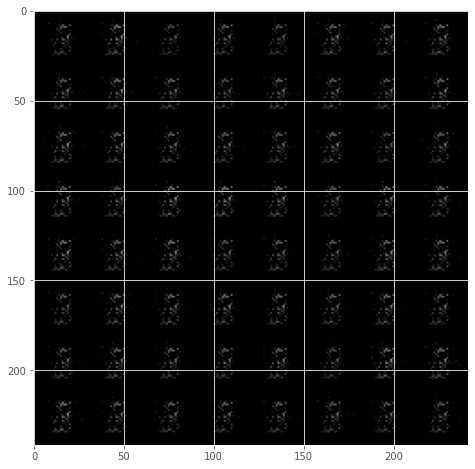

Generated images from Epoch number 21


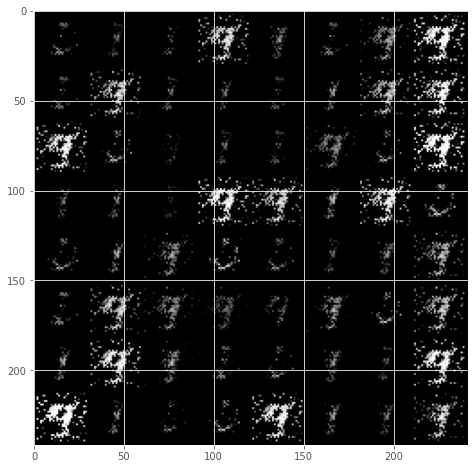

Generated images from Epoch number 41


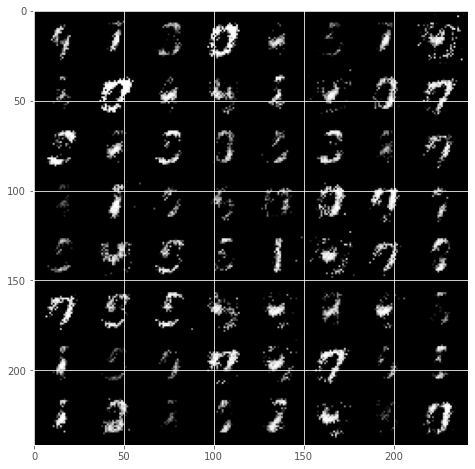

Generated images from Epoch number 61


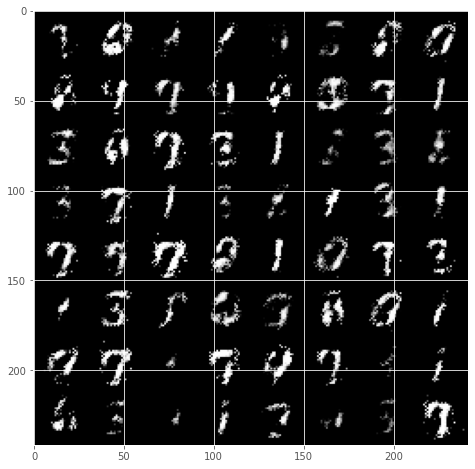

Generated images from Epoch number 81


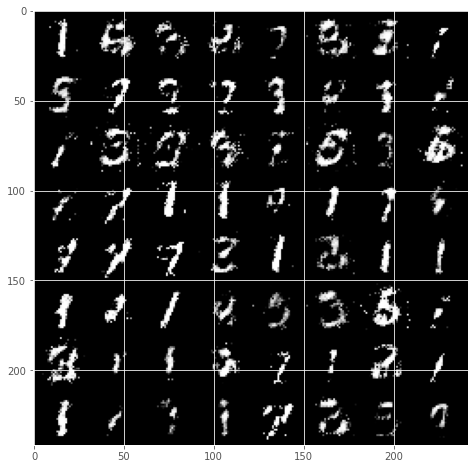

Generated images from Epoch number 101


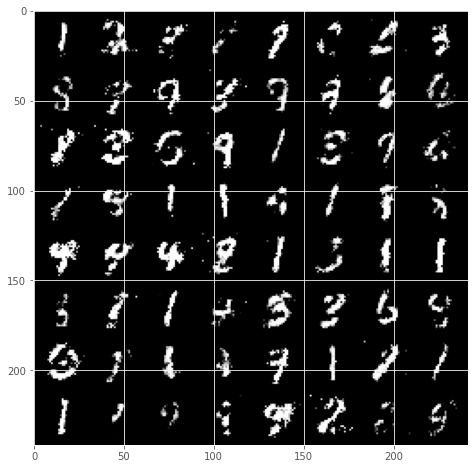

Generated images from Epoch number 121


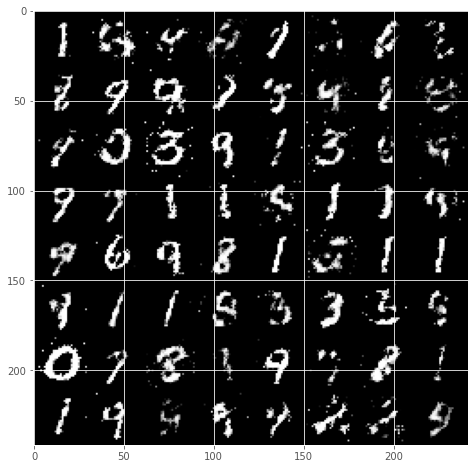

Generated images from Epoch number 141


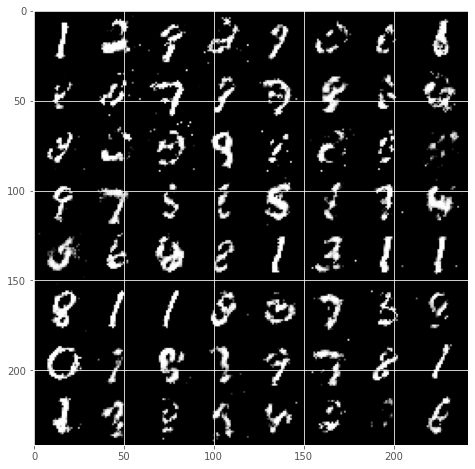

Generated images from Epoch number 161


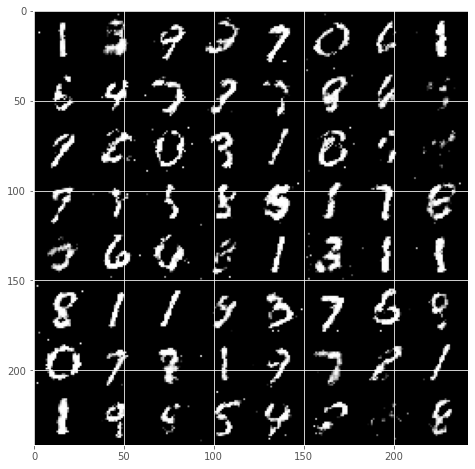

Generated images from Epoch number 181


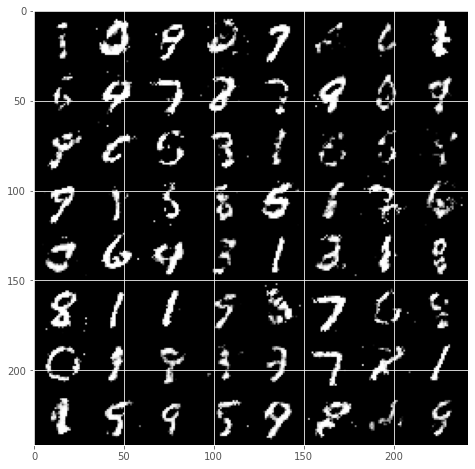

Generated images from Epoch number 200


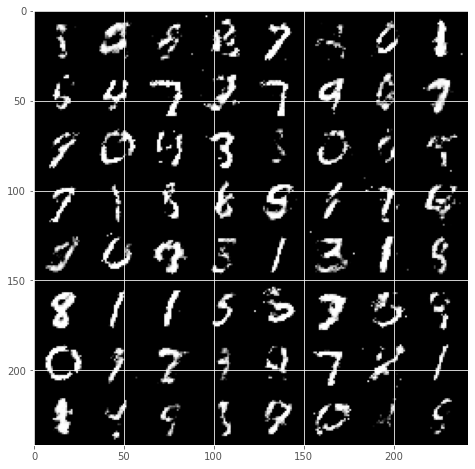

In [ ]:
path = '/content/GAN_outputs'
image_files = glob(os.path.join(path, '*.png'))

# Sort image files by the number in the file name
image_files.sort(key=lambda x: int(x.split('epoch')[1].split('.')[0]))

# Iterate over the sorted list of image files
for i, image_file in enumerate(image_files):
    epoch_num = int(image_file.split('epoch')[1].split('.')[0])
    if (epoch_num)%20==1 or epoch_num==200:
        print("Generated images from Epoch number", epoch_num)
        plt.figure(figsize=(8,8))  
        image = plt.imread(image_file)
        plt.imshow(image)
        plt.show()



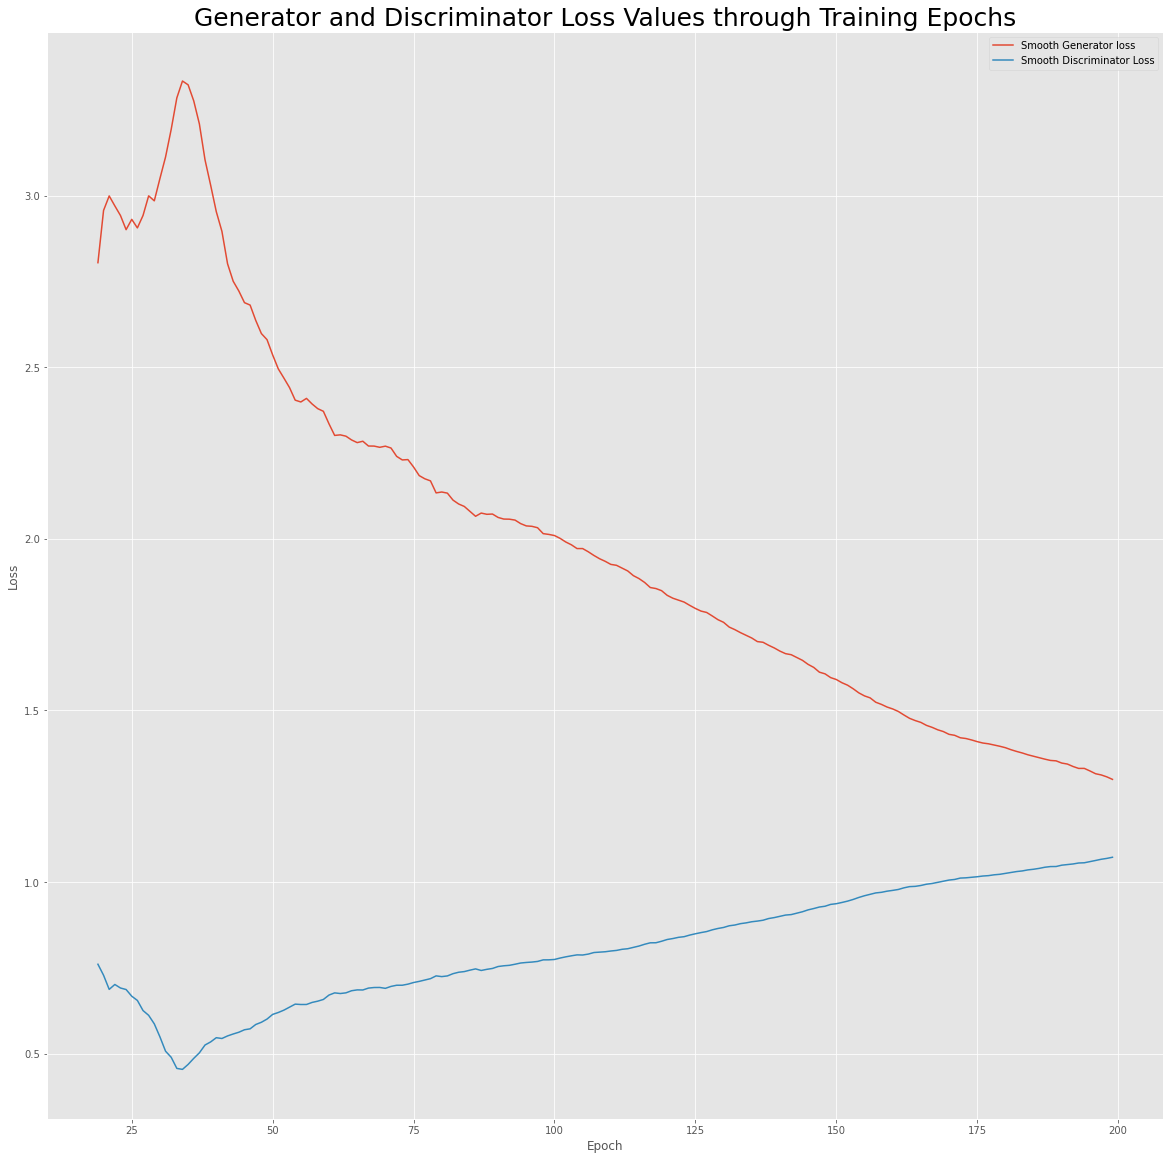

In [ ]:
losses_g_lst = [los.detach().item() for los in gan_losses_g]
losses_d_lst = [los.detach().item() for los in gan_losses_d]

losses_g_lst = pd.Series(losses_g_lst)
losses_d_lst = pd.Series(losses_d_lst)

losses_g_lst_smooth = losses_g_lst.rolling(window=20).mean()
losses_d_lst_smooth = losses_d_lst.rolling(window=20).mean()

plt.figure(figsize=(10,10)) 
plt.plot(losses_g_lst_smooth, label='Smooth Generator loss')
plt.plot(losses_d_lst_smooth, label='Smooth Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss Values through Training Epochs",fontsize =25)
plt.legend()
plt.show()

#Seccond Model - cGAN 

In [5]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()  
        self.z_size = z_size
        self.img_size = img_size
        self.label_emb = nn.Embedding(class_num, class_num)      
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, 256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Linear(256,512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(512,1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(-1, self.z_size)      
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(-1, self.img_size, self.img_size)

class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        self.img_size = img_size
        self.label_emb = nn.Embedding(class_num, class_num)
        self.model = nn.Sequential(
            nn.Linear(784 + class_num,1024),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2, inplace= True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, X, labels): 
        X = X.view(-1, 784)
        # One-hot encoding vector
        label = self.label_emb(labels)
        X = torch.cat([X, label], 1)
        output = self.model(X).squeeze()
        return output

In [6]:
def train_generator(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    f_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    f_images = generator(z, f_labels)
    g_loss = criterion(discriminator(f_images, f_labels), Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()  
    output = g_loss.data 
    return output

def train_discriminator(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    r_loss = criterion(discriminator(real_images, labels), Variable(torch.ones(batch_size)).to(device))
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    f_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    fake_images = generator(z, f_labels)
    f_loss = criterion(discriminator(fake_images, f_labels), Variable(torch.zeros(batch_size)).to(device))
    d_loss = r_loss + f_loss
    d_loss.backward()
    d_optimizer.step()
    output = d_loss.data
    return output

In [7]:
# Define - Generator and Discriminator

generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

# Define - loss function
criterion = nn.BCELoss()

# Define - Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

g_losses = []
d_losses = []

In [12]:
def train_mod(epochs):
  for epoch in range(epochs):
      for i, (images, labels) in enumerate(train_loader):
          r_images = Variable(images).to(device)
          labels = Variable(labels).to(device)
          generator.train()
          d_loss = train_discriminator(len(r_images), discriminator,generator, d_optimizer, criterion, r_images, labels)
          g_loss = train_generator(batch_size, discriminator, generator, g_optimizer, criterion)
      generator.eval()
      print('Epoch number: ', epoch+1, 'G loss is: ', round(g_loss.detach().item(),7), 'D loss is: ', round(d_loss.detach().item(),7))
      g_losses.append(g_loss)
      d_losses.append(d_loss)
      z = Variable(torch.randn(class_num, z_size)).to(device)
      labels = Variable(torch.LongTensor(np.arange(class_num))).to(device)
      imgs = generator(z, labels).unsqueeze(1).data.cpu()
      if (epoch+1)%20==1 or (epoch==199):
        print("Epoch Number ", epoch+1)
        plt.figure(figsize=(20,20))
        grid = make_grid(imgs, nrow=class_num, normalize=True).permute(1,2,0).numpy()
        plt.imshow(grid)
        plt.show()

Epoch number:  1 G loss is:  2.9268622 D loss is:  1.1875837
Epoch Number  1


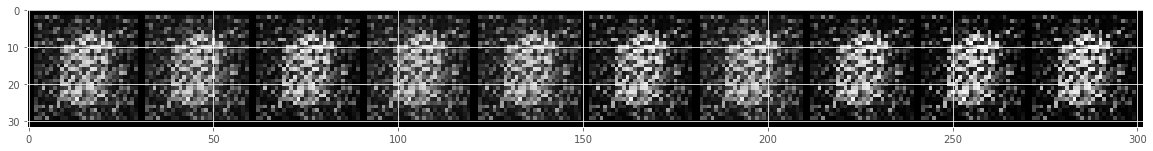

Epoch number:  2 G loss is:  2.4480801 D loss is:  1.0854173
Epoch number:  3 G loss is:  0.8068314 D loss is:  1.9938072
Epoch number:  4 G loss is:  2.160116 D loss is:  0.7836588
Epoch number:  5 G loss is:  1.3182906 D loss is:  0.7091395
Epoch number:  6 G loss is:  1.1173179 D loss is:  1.1352948
Epoch number:  7 G loss is:  1.6519785 D loss is:  0.7420937
Epoch number:  8 G loss is:  2.3936486 D loss is:  0.384079
Epoch number:  9 G loss is:  2.3643017 D loss is:  0.6522118
Epoch number:  10 G loss is:  2.7776303 D loss is:  0.3201811
Epoch number:  11 G loss is:  3.7186618 D loss is:  0.2362431
Epoch number:  12 G loss is:  3.7779298 D loss is:  0.414859
Epoch number:  13 G loss is:  4.2746444 D loss is:  0.1294607
Epoch number:  14 G loss is:  4.5453124 D loss is:  0.1755146
Epoch number:  15 G loss is:  5.6030273 D loss is:  0.1325168
Epoch number:  16 G loss is:  7.1070442 D loss is:  0.0664032
Epoch number:  17 G loss is:  5.862124 D loss is:  0.1117009
Epoch number:  18 G 

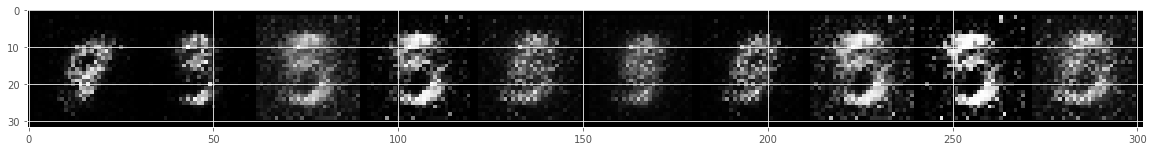

Epoch number:  22 G loss is:  3.968101 D loss is:  0.1614531
Epoch number:  23 G loss is:  5.7765126 D loss is:  0.2186556
Epoch number:  24 G loss is:  6.4357791 D loss is:  0.176825
Epoch number:  25 G loss is:  5.0097437 D loss is:  0.3224436
Epoch number:  26 G loss is:  5.1230202 D loss is:  0.1798014
Epoch number:  27 G loss is:  6.71662 D loss is:  0.1355499
Epoch number:  28 G loss is:  7.8676572 D loss is:  0.1715141
Epoch number:  29 G loss is:  7.4263058 D loss is:  0.0536031
Epoch number:  30 G loss is:  6.0948234 D loss is:  0.0981951
Epoch number:  31 G loss is:  6.7571063 D loss is:  0.1107394
Epoch number:  32 G loss is:  6.0353594 D loss is:  0.1717874
Epoch number:  33 G loss is:  4.9621496 D loss is:  0.1472444
Epoch number:  34 G loss is:  5.8317723 D loss is:  0.1280261
Epoch number:  35 G loss is:  5.2854495 D loss is:  0.1350035
Epoch number:  36 G loss is:  6.9705343 D loss is:  0.0870375
Epoch number:  37 G loss is:  6.4718714 D loss is:  0.1315876
Epoch number

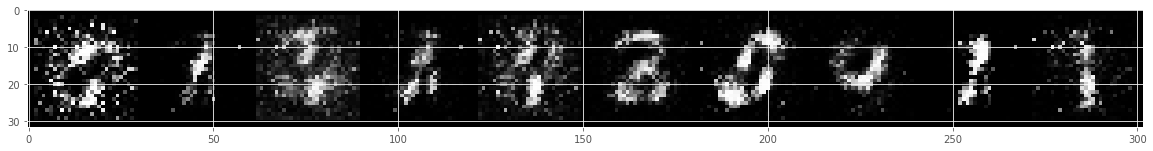

Epoch number:  42 G loss is:  4.9338808 D loss is:  0.1222052
Epoch number:  43 G loss is:  5.8403149 D loss is:  0.0632523
Epoch number:  44 G loss is:  5.4892492 D loss is:  0.1254114
Epoch number:  45 G loss is:  6.6200051 D loss is:  0.1056455
Epoch number:  46 G loss is:  7.1684241 D loss is:  0.1638584
Epoch number:  47 G loss is:  4.5381823 D loss is:  0.2051896
Epoch number:  48 G loss is:  5.4826956 D loss is:  0.2279982
Epoch number:  49 G loss is:  4.6691675 D loss is:  0.1297053
Epoch number:  50 G loss is:  5.2191892 D loss is:  0.1692013
Epoch number:  51 G loss is:  5.88762 D loss is:  0.1564147
Epoch number:  52 G loss is:  5.7218595 D loss is:  0.1925626
Epoch number:  53 G loss is:  4.9224072 D loss is:  0.2169116
Epoch number:  54 G loss is:  5.375205 D loss is:  0.1579004
Epoch number:  55 G loss is:  5.1241732 D loss is:  0.1929762
Epoch number:  56 G loss is:  3.7696991 D loss is:  0.4200605
Epoch number:  57 G loss is:  4.0880985 D loss is:  0.2619366
Epoch numbe

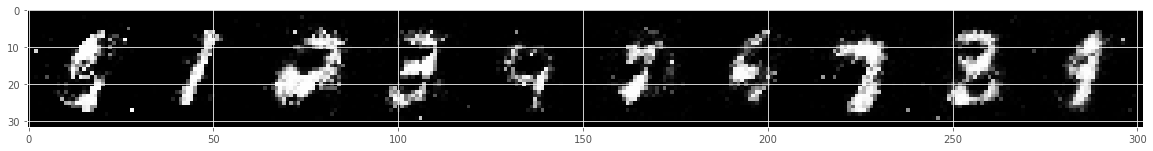

Epoch number:  62 G loss is:  4.4726052 D loss is:  0.2328587
Epoch number:  63 G loss is:  4.7746935 D loss is:  0.3340234
Epoch number:  64 G loss is:  3.4884057 D loss is:  0.2512886
Epoch number:  65 G loss is:  4.5160217 D loss is:  0.1694715
Epoch number:  66 G loss is:  4.2636905 D loss is:  0.323884
Epoch number:  67 G loss is:  4.7405548 D loss is:  0.3222832
Epoch number:  68 G loss is:  3.8760862 D loss is:  0.2821757
Epoch number:  69 G loss is:  3.4521639 D loss is:  0.3347548
Epoch number:  70 G loss is:  3.3807468 D loss is:  0.3565673
Epoch number:  71 G loss is:  3.5581722 D loss is:  0.3412221
Epoch number:  72 G loss is:  3.1516662 D loss is:  0.3410167
Epoch number:  73 G loss is:  4.0571418 D loss is:  0.3207707
Epoch number:  74 G loss is:  4.3706865 D loss is:  0.4324609
Epoch number:  75 G loss is:  3.1850958 D loss is:  0.4515071
Epoch number:  76 G loss is:  3.6301227 D loss is:  0.4284489
Epoch number:  77 G loss is:  3.2079759 D loss is:  0.4431047
Epoch num

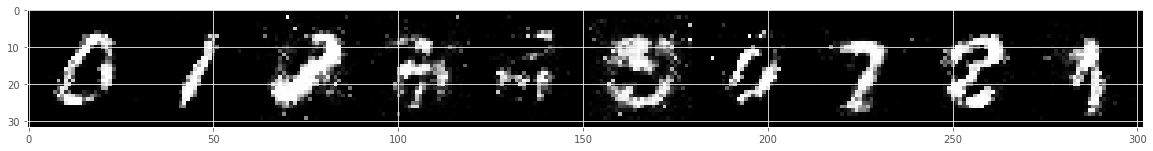

Epoch number:  82 G loss is:  3.0436797 D loss is:  0.5913913
Epoch number:  83 G loss is:  3.0706298 D loss is:  0.3865658
Epoch number:  84 G loss is:  3.0196924 D loss is:  0.4236305
Epoch number:  85 G loss is:  3.2381389 D loss is:  0.6748788
Epoch number:  86 G loss is:  3.0992103 D loss is:  0.418314
Epoch number:  87 G loss is:  2.4779718 D loss is:  0.5294058
Epoch number:  88 G loss is:  3.1689219 D loss is:  0.484145
Epoch number:  89 G loss is:  2.3815973 D loss is:  0.3849302
Epoch number:  90 G loss is:  3.1788497 D loss is:  0.3444433
Epoch number:  91 G loss is:  3.0664394 D loss is:  0.4259462
Epoch number:  92 G loss is:  2.7058311 D loss is:  0.4640523
Epoch number:  93 G loss is:  2.5659626 D loss is:  0.6237679
Epoch number:  94 G loss is:  2.9524298 D loss is:  0.4297305
Epoch number:  95 G loss is:  2.7687662 D loss is:  0.5205688
Epoch number:  96 G loss is:  3.3574319 D loss is:  0.4100921
Epoch number:  97 G loss is:  2.303277 D loss is:  0.555992
Epoch number

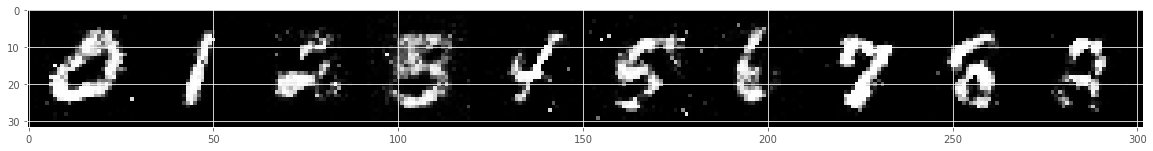

Epoch number:  102 G loss is:  2.9671273 D loss is:  0.6143916
Epoch number:  103 G loss is:  2.6734934 D loss is:  0.5371057
Epoch number:  104 G loss is:  2.2406831 D loss is:  0.644187
Epoch number:  105 G loss is:  2.6690474 D loss is:  0.6281304
Epoch number:  106 G loss is:  2.2017412 D loss is:  0.4394755
Epoch number:  107 G loss is:  2.2263119 D loss is:  0.778386
Epoch number:  108 G loss is:  2.5504351 D loss is:  0.7177953
Epoch number:  109 G loss is:  2.8898573 D loss is:  0.5614107
Epoch number:  110 G loss is:  2.416677 D loss is:  0.6282591
Epoch number:  111 G loss is:  2.5071042 D loss is:  0.5840592
Epoch number:  112 G loss is:  2.552556 D loss is:  0.6283406
Epoch number:  113 G loss is:  2.2238684 D loss is:  0.5484062
Epoch number:  114 G loss is:  1.9284106 D loss is:  0.651587
Epoch number:  115 G loss is:  2.5927446 D loss is:  0.6246101
Epoch number:  116 G loss is:  2.0427513 D loss is:  0.7740489
Epoch number:  117 G loss is:  1.9287889 D loss is:  0.56873

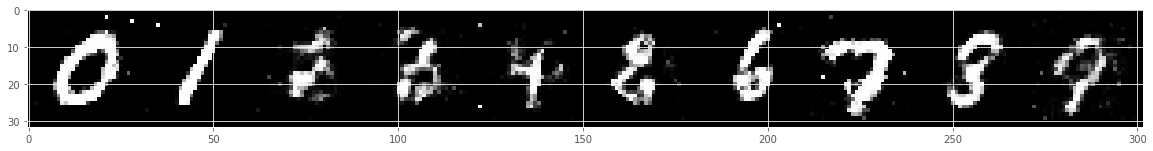

Epoch number:  122 G loss is:  2.3233733 D loss is:  0.7561345
Epoch number:  123 G loss is:  2.6913743 D loss is:  0.6408748
Epoch number:  124 G loss is:  2.952168 D loss is:  0.5955102
Epoch number:  125 G loss is:  2.2235527 D loss is:  0.6530366
Epoch number:  126 G loss is:  2.2653453 D loss is:  0.6636164
Epoch number:  127 G loss is:  1.6424508 D loss is:  0.9180485
Epoch number:  128 G loss is:  2.1964393 D loss is:  0.9283861
Epoch number:  129 G loss is:  2.3525009 D loss is:  0.7418076
Epoch number:  130 G loss is:  1.7784489 D loss is:  0.7793182
Epoch number:  131 G loss is:  1.643605 D loss is:  0.8630804
Epoch number:  132 G loss is:  1.740145 D loss is:  0.7179467
Epoch number:  133 G loss is:  1.9901459 D loss is:  0.7737129
Epoch number:  134 G loss is:  1.9671474 D loss is:  0.854784
Epoch number:  135 G loss is:  2.2630353 D loss is:  0.6595954
Epoch number:  136 G loss is:  1.529887 D loss is:  0.9961585
Epoch number:  137 G loss is:  1.8198612 D loss is:  1.08287

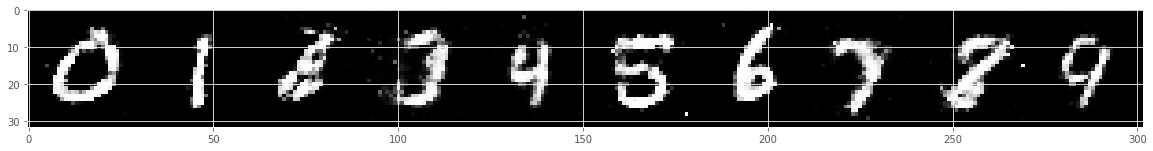

Epoch number:  142 G loss is:  1.7458682 D loss is:  0.8187017
Epoch number:  143 G loss is:  1.6752477 D loss is:  0.91198
Epoch number:  144 G loss is:  1.7545464 D loss is:  0.8040982
Epoch number:  145 G loss is:  1.5618802 D loss is:  0.8347605
Epoch number:  146 G loss is:  1.7194965 D loss is:  0.9013191
Epoch number:  147 G loss is:  1.9175472 D loss is:  1.1580312
Epoch number:  148 G loss is:  2.0289388 D loss is:  0.8394383
Epoch number:  149 G loss is:  1.7516415 D loss is:  0.9165168
Epoch number:  150 G loss is:  1.7624056 D loss is:  1.0220013
Epoch number:  151 G loss is:  1.7889662 D loss is:  0.7742514
Epoch number:  152 G loss is:  1.8473155 D loss is:  0.7755047
Epoch number:  153 G loss is:  1.6973852 D loss is:  0.9385251
Epoch number:  154 G loss is:  1.3815856 D loss is:  1.1090851
Epoch number:  155 G loss is:  1.6852479 D loss is:  1.0580192
Epoch number:  156 G loss is:  1.6306677 D loss is:  1.0381525
Epoch number:  157 G loss is:  1.6983945 D loss is:  0.93

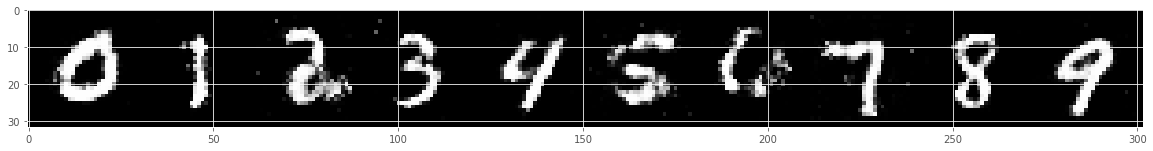

Epoch number:  162 G loss is:  1.5435984 D loss is:  0.9501623
Epoch number:  163 G loss is:  1.7069255 D loss is:  0.8752441
Epoch number:  164 G loss is:  1.5254265 D loss is:  1.0807216
Epoch number:  165 G loss is:  1.4212909 D loss is:  0.8969574
Epoch number:  166 G loss is:  2.1782308 D loss is:  0.9159107
Epoch number:  167 G loss is:  1.645331 D loss is:  0.8133051
Epoch number:  168 G loss is:  1.4619412 D loss is:  0.8250781
Epoch number:  169 G loss is:  1.8721132 D loss is:  0.9036158
Epoch number:  170 G loss is:  1.5748664 D loss is:  1.0242882
Epoch number:  171 G loss is:  1.6915193 D loss is:  0.9959952
Epoch number:  172 G loss is:  1.2756159 D loss is:  0.9457953
Epoch number:  173 G loss is:  1.5579729 D loss is:  1.110131
Epoch number:  174 G loss is:  1.5731882 D loss is:  0.9955013
Epoch number:  175 G loss is:  1.4563024 D loss is:  0.8441275
Epoch number:  176 G loss is:  1.5141116 D loss is:  1.0304286
Epoch number:  177 G loss is:  1.6400969 D loss is:  0.90

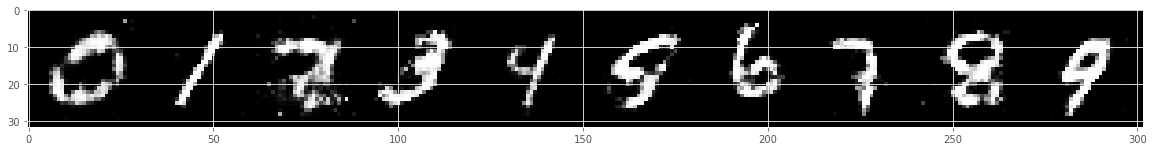

Epoch number:  182 G loss is:  1.3945228 D loss is:  0.9273316
Epoch number:  183 G loss is:  1.684011 D loss is:  1.0339794
Epoch number:  184 G loss is:  1.6526973 D loss is:  0.9566709
Epoch number:  185 G loss is:  1.6059046 D loss is:  0.9006966
Epoch number:  186 G loss is:  1.66167 D loss is:  0.972165
Epoch number:  187 G loss is:  1.2928019 D loss is:  0.9552782
Epoch number:  188 G loss is:  1.6099615 D loss is:  0.8844197
Epoch number:  189 G loss is:  1.6316499 D loss is:  0.9750259
Epoch number:  190 G loss is:  1.2434652 D loss is:  0.9273404
Epoch number:  191 G loss is:  1.3714509 D loss is:  0.9734983
Epoch number:  192 G loss is:  1.3290882 D loss is:  1.0176471
Epoch number:  193 G loss is:  1.3431003 D loss is:  1.003547
Epoch number:  194 G loss is:  1.2374549 D loss is:  1.0207165
Epoch number:  195 G loss is:  2.0866151 D loss is:  0.9458785
Epoch number:  196 G loss is:  1.4347136 D loss is:  0.9810358
Epoch number:  197 G loss is:  1.2237967 D loss is:  1.02111

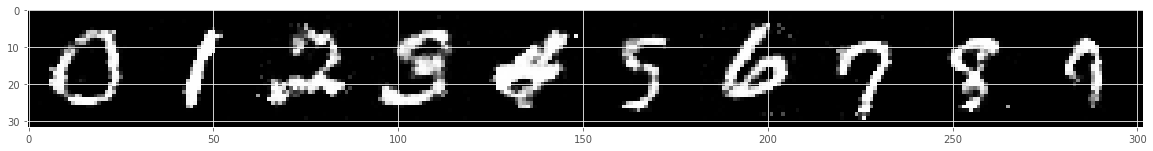

In [13]:
train_mod(epochs)

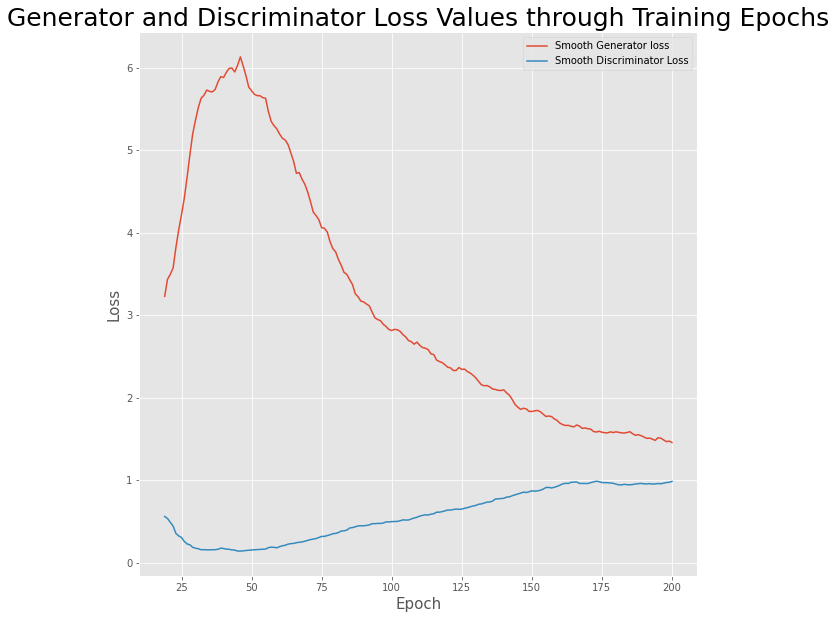

In [15]:
g_losses_lst = [los.detach().item() for los in g_losses]
d_losses_lst = [los.detach().item() for los in d_losses]
losses_g_lst = pd.Series(g_losses_lst)
losses_d_lst = pd.Series(d_losses_lst)
losses_g_lst_smooth = losses_g_lst.rolling(window=20).mean()
losses_d_lst_smooth = losses_d_lst.rolling(window=20).mean()

plt.figure(figsize=(10,10)) 
plt.plot(losses_g_lst_smooth, label='Smooth Generator loss')
plt.plot(losses_d_lst_smooth, label='Smooth Discriminator Loss')
plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.title("Generator and Discriminator Loss Values through Training Epochs",fontsize =25)
plt.legend()
plt.show()